In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.misc
import random
from tqdm import tqdm
from skimage.color import rgba2rgb,rgb2gray

In [2]:
os.chdir('..')

In [3]:
w,h = 64,64
datadir = os.getcwd()+'/data/'
print(datadir)
X = []
for f in os.listdir(datadir):
    img = scipy.misc.imread(datadir+f, mode='RGBA')
    img = rgb2gray(rgba2rgb(img))
    img = scipy.misc.imresize(img, (w, h, 1))
    X.append(img)
X = np.asarray(X)

C:\Users\Jake\Downloads\Proj1/data/


In [7]:
print(X.shape)

(1403, 28, 28)


In [4]:
# split into train and test sets
random.seed(19930614)
np.random.shuffle(X)
X_train = X
X_test = X

In [5]:
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'testing samples')

257 training samples
257 testing samples


In [6]:
# normalize the sets between 0 and 1
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [7]:
# reshape sets
X_train = np.reshape(X_train, (len(X_train), w, h, 1))
X_test = np.reshape(X_test, (len(X_test), w, h, 1))

In [8]:
from keras.layers import Input, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, UpSampling2D, \
BatchNormalization, Reshape, Activation
from keras.initializers import RandomUniform
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras import backend as K
from keras import metrics

Using TensorFlow backend.


In [9]:
# build the generator
num_noise = 100
gen_input = Input(shape=(num_noise,)) 
layer = Dense(num_noise*w//4*h//4, kernel_initializer='glorot_normal')(gen_input)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Reshape( (w//4,h//4,num_noise) )(layer)
layer = UpSampling2D(size=(4,4))(layer)
layer = Dropout(0.5)(layer)
layer = Conv2D(64, (3, 3), padding='same', kernel_initializer='glorot_uniform')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Conv2D(32, (3, 3), padding='same', kernel_initializer='glorot_uniform')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(layer)
gen_val = Activation('sigmoid')(layer) # final output is a value between 0 and 1

gen_opt = Adam(lr=1e-4)
generator = Model(gen_input, gen_val)
generator.compile(loss='binary_crossentropy', optimizer=gen_opt)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25600)             2585600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 25600)             102400    
_________________________________________________________________
activation_1 (Activation)    (None, 25600)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 100)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 100)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 100)       0         
__________

In [10]:
# build the discriminator
dis_input = Input(shape=(w,h,1))
layer = Conv2D(128, (5,5), padding='same', activation='relu')(dis_input)
layer = LeakyReLU(0.2)(layer)
layer = Dropout(0.5)(layer)
layer = Conv2D(64, (5,5), padding='same', activation='relu')(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dropout(0.5)(layer)
layer = Flatten()(layer)
layer = Dense(32)(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dropout(0.5)(layer)
dis_val = Dense(2, activation='softmax')(layer)

dis_opt = Adam(lr=1e-3)
discriminator = Model(dis_input,dis_val)
discriminator.compile(loss='categorical_crossentropy',optimizer=dis_opt)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       3328      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 64)        0         
__________

In [11]:
# define a function to freeze the weights on the discriminator
# (we don't want backpropogation to occur for the discriminator when training the GAN)
def toggle_trainable(network, flag):
    network.trainable = flag
    for layer in network.layers:
        layer.trainable = flag

In [12]:
toggle_trainable(discriminator, False)

In [13]:
# build the GAN!
GAN_input = Input(shape=(num_noise,))
layer = generator(GAN_input)
GAN_val = discriminator(layer)
GAN = Model(GAN_input, GAN_val)
GAN.compile(loss='categorical_crossentropy', optimizer=gen_opt)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 1)         2764545   
_________________________________________________________________
model_2 (Model)              (None, 2)                 8596898   
Total params: 11,361,443.0
Trainable params: 2,713,153.0
Non-trainable params: 8,648,290.0
_________________________________________________________________


In [14]:
### pre-train the discriminator ###
# generate noise
noise = np.random.uniform(low=0.0, high=1.0, size=((len(X_train),num_noise)))# this is z
print(len(noise), 'noise samples')

257 noise samples


In [15]:
# plot the noise for fun
plt.figure(figsize=(20,2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(noise[i].reshape(w,h))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print('Looks like TV static lol')

ValueError: cannot reshape array of size 100 into shape (64,64)

In [17]:
# 
gen_imgs = generator.predict(noise)

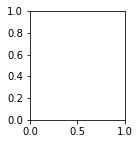

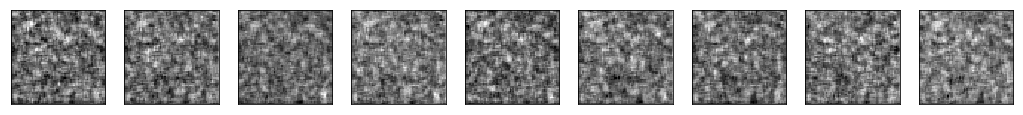

Looks like TV static lol


In [18]:
plt.figure(figsize=(20,2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(gen_imgs[i].reshape(w,h))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print('Looks like TV static lol')

In [19]:
pretrain_X_train = np.concatenate((X_train,gen_imgs))
n = X_train.shape[0]
y = np.zeros((2*n,2))
y[:n,1] = 1
y[n:,0] = 1

toggle_trainable(discriminator,True)

In [20]:
discriminator.fit(pretrain_X_train,y,
                 epochs=5,
                 batch_size=32,
                 shuffle=True,
                 verbose=2)

Epoch 1/5
2s - loss: 0.6034
Epoch 2/5
1s - loss: 0.1604
Epoch 3/5
1s - loss: 9.3830e-04
Epoch 4/5
1s - loss: 1.7680e-04
Epoch 5/5
1s - loss: 1.9936e-04


In [21]:
y_predicted = discriminator.predict(pretrain_X_train)

In [22]:
y_hat_idx = np.argmax(y_predicted,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_right = (diff==0).sum()
accuracy = n_right*100.0/n_tot
print("Accuracy: %0.2f pct (%d of %d) correct"%(accuracy,n_right,n_tot))


Accuracy: 100.00 pct (514 of 514) correct


In [23]:
loss_dict = {'d':[], 'g':[]}

In [24]:
def train_GAN(num_epochs=1000, batch_size=32):
    

    for e in tqdm(range(num_epochs)):


        # sample from noise
        noise = np.random.uniform(0.0, 1.0, size=(batch_size,num_noise))

        # run noise through the generator to get G(z)
        gen_imgs = generator.predict(noise)

        # sample from true data distribution
        np.random.shuffle(X_train)
        true_img_batch = X_train[:batch_size,:,:,:]

        # combine G(z) and true sample
        this_epoch_X = np.concatenate((true_img_batch, gen_imgs))

        # create true class response var
        y = np.zeros((2*batch_size,2))
        y[:batch_size,1] = 1
        y[batch_size:,0] = 1

        # train the discriminator
        toggle_trainable(discriminator,True)
        dis_loss = discriminator.train_on_batch(this_epoch_X, y)
        loss_dict['d'].append(dis_loss)

        # create GAN response var
        noise_tr = np.random.uniform(0.0, 1.0, size=(batch_size,num_noise))
        y2 = np.zeros((batch_size,2))
        y2[:,1] = 1

        # train GAN
        toggle_trainable(discriminator,False)
        gan_loss = GAN.train_on_batch(noise_tr, y2)
        loss_dict['g'].append(gan_loss)

In [25]:
# train GAN for 250 epochs
train_GAN(num_epochs=100, batch_size=32)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.28it/s]


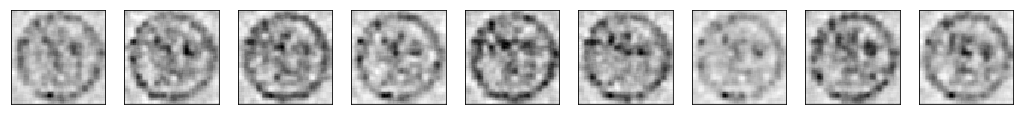

In [26]:
# view the quality of the generated "fake" images after 250 iterations of training
plt.figure(figsize=(20,2))
noise = np.random.uniform(0.0, 1.0, size=(10,num_noise))
gen_imgs = generator.predict(noise)
for i in range(1,10):
    
    ax = plt.subplot(1, 10, i)
    plt.imshow(gen_imgs[i].reshape(w,h))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
# train GAN for 100 more epochs
K.set_value(gen_opt.lr,1e-4)
K.set_value(dis_opt.lr,1e-5)
train_GAN(num_epochs=100, batch_size=16)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.65it/s]


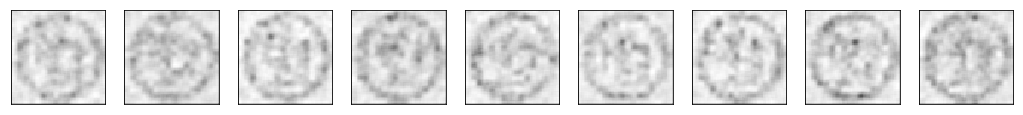

In [28]:
# view the quality of the generated "fake" images after 1000 iterations of training
plt.figure(figsize=(20,2))
noise = np.random.uniform(0.0, 1.0, size=(10,num_noise))
gen_imgs = generator.predict(noise)
for i in range(1,10):
    
    ax = plt.subplot(1, 10, i)
    plt.imshow(gen_imgs[i].reshape(w,h))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
# train GAN for 5000 more epochs
train_GAN(num_epochs=500, batch_size=16)

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [01:43<00:00,  5.15it/s]


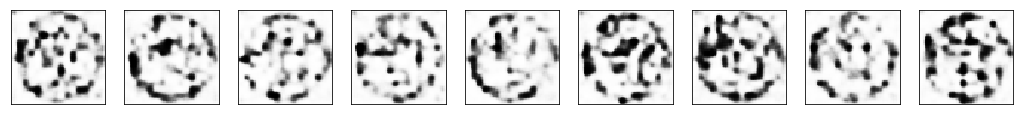

In [30]:
# view the quality of the generated "fake" images after 1000 iterations of training
plt.figure(figsize=(20,2))
noise = np.random.uniform(0.0, 1.0, size=((len(X_train),num_noise)))
gen_imgs = generator.predict(noise)
for i in range(1,10):
    
    ax = plt.subplot(1, 10, i)
    plt.imshow(gen_imgs[i].reshape(w,h))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [31]:
# train GAN for 10000 more epochs
train_GAN(num_epochs=10000, batch_size=32)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [49:35<00:00,  3.51it/s]


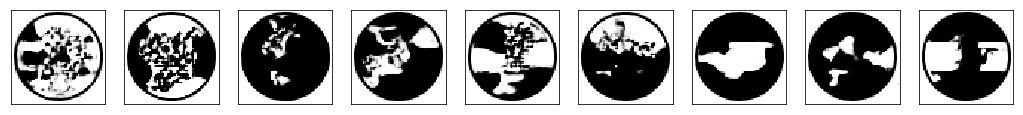

In [47]:
# view the quality of the generated "fake" images after 1000 iterations of training
plt.figure(figsize=(20,2))
noise = np.random.uniform(0.0, 1.0, size=((len(X_train),num_noise)))
gen_imgs = generator.predict(noise)
for i in range(1,10):
    
    ax = plt.subplot(1, 10, i)
    plt.imshow(gen_imgs[i].reshape(w,h))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

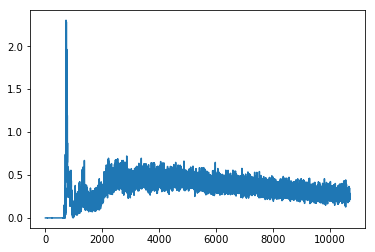

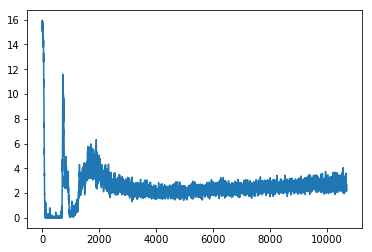

In [36]:
plt.plot(loss_dict['d'])
plt.show()
plt.plot(loss_dict['g'])
plt.show()

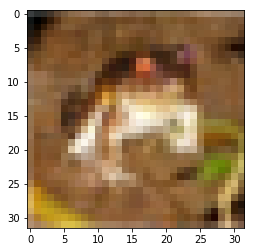

In [12]:

plt.imshow(X_train[0])
plt.show()